## Tuto fonction fastmri

## Import

In [1]:
import sys
sys.path.append('/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon')

In [2]:
from fastmri.data import transforms as T
import h5py
import torch
import numpy as np
from matplotlib import pyplot as plt

from utils_torch import virtual_coil_reconstruction, show_coils, load_and_transform, create_masked_Image
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.models.unet import Unet


In [3]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size'] = 16

## Download data 

In [4]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"
kspace_m = load_and_transform(file_path)

Les données sont complex.  
Shape = [Batch , coils , H, W]

In [5]:
K = virtual_coil_reconstruction(torch.fft.fftshift(torch.fft.ifft2(kspace_m)))

## Multicoil to Singlecoil

In [6]:
kspace = virtual_coil_reconstruction(kspace_m)
kspace.shape

torch.Size([16, 640, 320])

In [7]:
image = torch.fft.fftshift(torch.fft.ifft2(kspace))

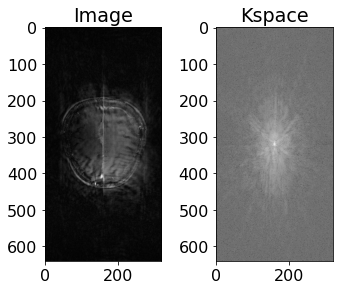

In [8]:
plt.subplot(1,2,1)
plt.imshow(np.abs(image[0, :,: ].numpy()))
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(np.log(np.abs(kspace[0, :, :])))
plt.title("Kspace")

plt.tight_layout()
plt.show()

## Test for undersampling Mask 

### Fastmri

Choose the sampling mask you want between the following.

random : genere a sampling mask randomly  
equispaced : genere a sampling mask with qually-spaced k-space lines  
equispaced_fraction : similar to equispaced with more precision about acceleration rate  
magic : genere a sampling mask who exploit conjugate symmetry  
magic_fraction : similar to magic with more precision about acceleration rate  

In [9]:
mask_type = "magic_fraction"
center_fractions = [0.08, 0.04]
accelerations = [4, 8]

mask = create_mask_for_mask_type(mask_type, center_fractions, accelerations)

masked_func represent here the binary data of the mask.   
0 mean informatiosn in the data are note conserve.   
1 mean you take the information.   
    
accelerated_data is the fusion between the original data and sampling data.   
This is the data we gonna use.

In [10]:
masked_image = create_masked_Image(mask, kspace)

In [11]:
# masked_data , _ = mask(kspace.shape) 
# masked_kspace = kspace * masked_data
# masked_kspace.shape

In [12]:
# masked_image = torch.fft.fftshift(torch.fft.ifft2(masked_kspace))

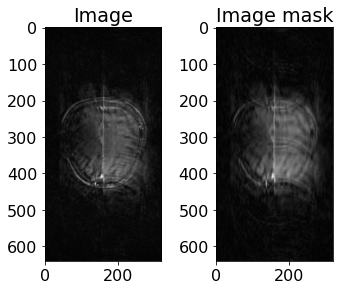

In [13]:
plt.subplot(1,2,1)
plt.imshow(np.abs(image[0, :,: ].numpy()))
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(np.abs(masked_image[0, 0, :,: ].numpy()))
plt.title("Image mask")

plt.tight_layout()
plt.show()

### Fasmri Reproductible Benchmark

In [14]:
from data.gen_mask_torch import gen_mask_torch

In [15]:
#  Representation binaire qui indique quel point sera conservé. 

masked_data1 = gen_mask_torch(kspace, accel_factor= 4 , multicoil= False , fixed_masks=False)
masked_kspace1 = kspace* masked_data1

In [16]:
masked_image1 = torch.fft.fftshift(torch.fft.ifft2(masked_kspace1))

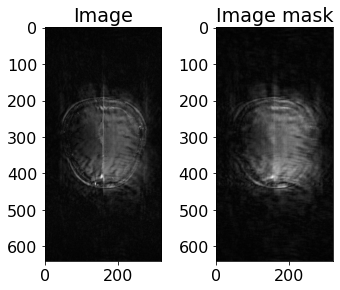

In [17]:
plt.subplot(1,2,1)
plt.imshow(np.abs(image[0, :,: ].numpy()))
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(np.abs(masked_image1[0, :,: ].numpy()))
plt.title("Image mask")

plt.tight_layout()
plt.show()

## Modele Reseaux Neurones

Train Model

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torch.autograd import Variable



Model

In [19]:
# masked_image = masked_image.unsqueeze(1)
# masked_image = masked_image.abs()
# model = Unet(in_chans=masked_image.shape[1], out_chans=1, chans=20 , num_pool_layers=4)
# output = model(masked_image)

K = K.unsqueeze(1)
K = K.abs()

In [20]:
train_image = masked_image
train_label = K

train_dataset = TensorDataset(train_image, train_label)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = Unet(in_chans=1, out_chans=1, chans=20, num_pool_layers=4)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
print(train_image.shape)
print(train_image.dtype)

print(train_label.shape)
print(train_label.dtype)


torch.Size([16, 1, 640, 320])
torch.float32
torch.Size([16, 1, 640, 320])
torch.float32


In [22]:
num_epochs = 2
for epoch in range(num_epochs):
    for batch_images, batch_labels in train_loader:
        # Mettre les données dans le bon format
        inputs = Variable(batch_images)
        targets = Variable(batch_labels)

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Passe avant
        outputs = model(inputs)

        # Calcul de la perte
        loss = criterion(outputs, targets)
        print(loss)

        # Passe arrière et mise à jour des poids
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# # Sauvegarder le modèle
# torch.save(model.state_dict(), 'unet_model.pth')

tensor(0.2209, grad_fn=<MseLossBackward0>)
Epoch [1/2], Loss: 0.22094911336898804
tensor(0.1169, grad_fn=<MseLossBackward0>)
Epoch [2/2], Loss: 0.1168590560555458


In [23]:
torch.save(model.state_dict(), 'fastmri_unet_model.pth')

In [24]:
model = Unet(in_chans=1, out_chans=1, chans=20, num_pool_layers=4)
model.load_state_dict(torch.load('fastmri_unet_model.pth'))

<All keys matched successfully>

In [25]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002787.h5"
hf = h5py.File(file_path)
kspace_m = hf['kspace'][()]
kspace_m = torch.tensor(kspace_m, dtype=torch.complex64)
kspace = virtual_coil_reconstruction(kspace_m)
masked_data , _ = mask(kspace.shape) 
masked_kspace = kspace * masked_data
masked_image = torch.fft.fftshift(torch.fft.ifft2(masked_kspace))
masked_image = masked_image.unsqueeze(1)
masked_image = masked_image.abs()

test_image = masked_image

print(test_image.shape)
print(test_image.dtype)

torch.Size([16, 1, 640, 320])
torch.float32


In [26]:
model.eval()

Unet(
  (down_sample_layers): ModuleList(
    (0): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropout2d(p=0.0, inplace=False)
        (4): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): InstanceNorm2d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (6): LeakyReLU(negative_slope=0.2, inplace=True)
        (7): Dropout2d(p=0.0, inplace=False)
      )
    )
    (1): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropout2

In [27]:
with torch.no_grad():
    predicted_images = model(test_image)

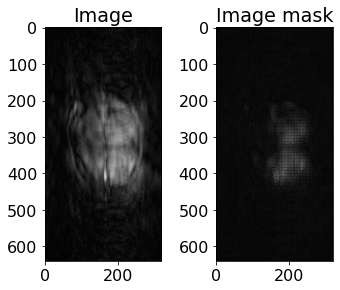

In [28]:
plt.subplot(1,2,1)
plt.imshow(np.abs(test_image[0, 0, :,: ].numpy()))
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(np.abs(predicted_images[0, 0, :,: ].numpy()))
plt.title("Image mask")

plt.tight_layout()
plt.show()